In [1]:
import tracking as tk

In [2]:
import cv2
import numpy as np
import tifffile as tiff
import imageio

In [10]:
# Load the multi-frame .tif image
image_path = 'D:\Temp_WS_10_2023\RAW_IMG\pilG_dilute_PC.tif'
with tiff.TiffFile(image_path) as tif:
#    frames = tif.asarray()
     frame = tif.asarray(key=0)
# Process the first few frames
# num_frames_to_process = 5
# for i in range(min(num_frames_to_process, frames.shape[0])):
#     frame = frames[i]
#     particles = imp.detect_particles(frame)

In [4]:
image=frame

# Preprocess
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = image
# Apply bilateral filter
bilateral = cv2.bilateralFilter(gray, 25, 50, 50)

# Apply Otsu's thresholding
_, binary = cv2.threshold(bilateral, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological opening to remove small noise
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

In [5]:
simg=opening
aspect_ratio = simg.shape[1] / float(simg.shape[0])
desired_width = 600
desired_height = int(desired_width / aspect_ratio)
resized = cv2.resize(simg, (desired_width, desired_height))
cv2.imshow('Resized Image with Aspect Ratio', resized)
cv2.waitKey(0)

-1

In [63]:
simg.shape[1]

2048

## End2End Contoured based Segmentation and Tracking

In [8]:
def detect_edges(image, sigma=0.33):
 """
    Detect edges in the image using the Canny edge detector.
    
    Parameters:
    - image: Grayscale image.
    - sigma: Proportion to adjust the automatic thresholding. (default is 0.33)
    
    Returns:
    - edges: Binary image with detected edges.
    """
    # Compute the median of the single channel pixel intensities
    v= np.median(image)
    
    # Apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    
    edges = cv2.Canny(image, lower, upper)
    
    return edges

IndentationError: unexpected indent (1909471305.py, line 13)

In [17]:
def adaptive_edge_detection(image, block_size=10, sigma=0.05):
    """
    Perform adaptive edge detection on the image.
    
    Parameters:
    - image: Grayscale image.
    - block_size: Size of the local region/block.
    - sigma: Proportion to adjust the automatic thresholding.
    
    Returns:
    - edge_detected_image: Image with detected edges.
    """
    height, width = image.shape
    edge_detected_image = np.zeros_like(image)
    
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            # Extract the block from the image
            block = image[y:y+block_size, x:x+block_size]
            
            # Compute the median of the block
            v = np.median(block)
            
            # Set the thresholds based on the block's median
            lower = int(max(0, (1.0 - sigma) * v))
            upper = int(min(255, (1.0 + sigma) * v))
            
            # Apply Canny edge detection to the block
            edges = cv2.Canny(block, lower, upper)
            
            # Place the detected edges in the result image
            edge_detected_image[y:y+block_size, x:x+block_size] = edges
            
    return edge_detected_image

In [18]:
def visualize_edges(original_image, edges):
    """
    Visualize the detected edges.
    
    Parameters:
    - original_image: Original grayscale image.
    - edges: Binary image with detected edges.
    """
    # Overlay the edges on the original image
    overlay = cv2.addWeighted(original_image, 0.8, edges, 0.2, 0)
    
    # Display the original image
    cv2.imshow('Original Image', original_image)
    
    # Display the edges
    cv2.imshow('Detected Edges', edges)
    
    # Display the overlay
    cv2.imshow('Overlay', overlay)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [19]:
def visualize_edges_red(original_image, edges):
    """
    Visualize the detected edges in red.
    
    Parameters:
    - original_image: Original grayscale image.
    - edges: Binary image with detected edges.
    """
    # Convert the original grayscale image to a 3-channel image
    colored_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    
    # Create a blank image with the same dimensions as the original
    red_edges = np.zeros_like(colored_image)
    
    # Set the red channel to the detected edges
    red_edges[:, :, 2] = edges
    
    # Overlay the red edges onto the original image
    overlay = cv2.addWeighted(colored_image, 1, red_edges, 0.5, 0)
    
    # Display the original image
   # cv2.imshow('Original Image', original_image)
    return overlay

In [20]:
def visualize_contours(image, contours, color=(0, 255, 0), thickness=2):
    """
    Visualize the detected contours on the image.
    
    Parameters:
    - image: Original grayscale or color image.
    - contours: Detected contours.
    - color: Color of the contours (default is green).
    - thickness: Thickness of contour lines.
    
    Returns:
    - contoured_image: Image with drawn contours.
    """
    # If the image is grayscale, convert it to color
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    contoured_image = image.copy()
    cv2.drawContours(contoured_image, contours, -1, color, thickness)
    
    return contoured_image

In [15]:
# Detect edges
edges = adaptive_edge_detection(frame)
overlay=visualize_edges_red(frame, edges)

simg=overlay
aspect_ratio = simg.shape[1] / float(simg.shape[0])
desired_width = 500
desired_height = int(desired_width / aspect_ratio)
resized = cv2.resize(simg, (desired_width, desired_height))
cv2.imshow('Edge in Red', resized)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [59]:
cv2.imwrite('overlay_image.png', overlay, [cv2.IMWRITE_PNG_COMPRESSION, 0])

True

In [16]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoured_image=visualize_contours(frame, contours, color=(0, 255, 0), thickness=1)
# Display the image with contours
cv2.imshow('Contours', contoured_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [51]:
# The class process the grayscale images instead of binary images

class BacteriaTracker2:
    def __init__(self,thre,f_path,cw,fw,f_len):
        self.historical_data = {}  # Store historical data for each bacterium
        self.bacteria_data = []
        self.next_id = 0
        self.SOME_THRESHOLD=thre
        self.f_path=f_path
        self.centroid_weight=cw
        self.feature_weight=fw
        self.fen=f_len
    def extract_features(self, contour):
        # ... [Same as the extract_features function provided above]
            # Centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0
    
        # Area
        area = cv2.contourArea(contour)
    
        # Bounding box to get aspect ratio
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
    
        # Solidity
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area != 0 else 0
    
        # Perimeter
        perimeter = cv2.arcLength(contour, True)
    
        # Circularity
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter != 0 else 0
    
        return {
            'centroid': (cx, cy),
            'area': area,
            'aspect_ratio': aspect_ratio,
            'solidity': solidity,
            'perimeter': perimeter,
            'circularity': circularity
        }
    def compute_similarity(self, bacteria1, bacteria2):
        # ... [Same as the compute_similarity function provided above]
        # Compute the Euclidean distance between centroids
        c1 = np.array(bacteria1['centroid'])
        c2 = np.array(bacteria2['centroid'])
        centroid_distance = np.linalg.norm(c1 - c2)
        
        # Create feature vectors for each bacteria
        features1 = np.array([
            bacteria1['area'],
            bacteria1['aspect_ratio'],
            bacteria1['solidity'],
            bacteria1['perimeter'],
            bacteria1['circularity']
        ])
        
        features2 = np.array([
            bacteria2['area'],
            bacteria2['aspect_ratio'],
            bacteria2['solidity'],
            bacteria2['perimeter'],
            bacteria2['circularity']
        ])
        
        # Compute the Euclidean distance between feature vectors
        feature_distance = np.linalg.norm(features1 - features2)
        
        # Combine the distances using the given weights
        total_distance = self.centroid_weight * centroid_distance + self.feature_weight * feature_distance
        
        return total_distance
    def process_first_frame(self, binary_image):
        # Detect edges using Canny
        #edges = cv2.Canny(binary_image, 50, 150)
        edges = adaptive_edge_detection(binary_image)
        # Detect contours on the edge-detected image
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        min_contour_area = 50
        contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        for contour in contours:
            features = self.extract_features(contour)
            self.bacteria_data.append({
                'id': self.next_id,
                'features': features
            })
            self.next_id += 1
        self.historical_data[0] = [(bacteria['id'], bacteria['features']['centroid']) for bacteria in self.bacteria_data]

    def process_frame(self, binary_image, frame_index):
        # Detect edges using Canny
        #edges = cv2.Canny(binary_image, 50, 150)
        edges = adaptive_edge_detection(binary_image)
        # Detect contours on the edge-detected image
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        min_contour_area = 50
        contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        new_bacteria_data = []
        matched_ids = set()  # To keep track of IDs that have been matched in this frame
        new_added_ids = set()  # Set to store the IDs of newly added bacteria
        used_ids = set()  # Set to keep track of IDs that have been used in this frame
        
        for contour in contours:
            features = self.extract_features(contour)
            best_match = None
            best_similarity = float('inf')

            for prev_bacteria in self.bacteria_data:
            # Skip if this ID has already been used in this frame
                if prev_bacteria['id'] in used_ids:
                    continue
                similarity = self.compute_similarity(prev_bacteria['features'], features)
                if similarity < best_similarity:
                    best_similarity = similarity
                    best_match = prev_bacteria

            if best_similarity < self.SOME_THRESHOLD:  # Define a threshold based on your data
                new_bacteria_data.append({
                    'id': best_match['id'],
                    'features': features
                })
                matched_ids.add(best_match['id'])
                used_ids.add(best_match['id'])  # Mark this ID as used
            # print(best_similarity)
            # similarity metrics needs to be changed
            else:
                self.next_id += 1
                new_bacteria_data.append({
                    'id': self.next_id,
                    'features': features
                })
                new_added_ids.add(self.next_id)  # Add the new ID to the new_added_ids set
                
        # Combine matched_ids and new_added_ids
        valid_ids = matched_ids.union(new_added_ids)
    
        # Filter out bacteria data that didn't find a match in this frame
        self.bacteria_data = [b for b in new_bacteria_data if b['id'] in valid_ids]
        # store frame data
        self.historical_data[frame_index] = [(bacteria['id'], bacteria['features']['centroid']) for bacteria in self.bacteria_data]
        #self.bacteria_data = new_bacteria_data
    def extract_frames(self,idx):
        with tiff.TiffFile(self.f_path) as tif:
#    frames = tif.asarray()
             fra3 = tif.asarray(key=idx)
            #preprocessing code
            # fra3b = cv2.bitwise_not(fra3)
        return fra3
    def process_frames(self):
        fra1=self.extract_frames(0)
        self.process_first_frame(fra1)
        for idx in range(1,self.fen):
            frap=self.extract_frames(idx)
            print(f"Processing image {idx}/{self.fen}...")
            self.process_frame(frap,idx)
    def visualize_trajectories(self):
        # This will store the trajectories of each bacteria
        #trajectories = {}

        # This will store the visualizations for each frame
        visualizations = []

        for idx in range(0,self.fen):
            print(f"Processing image visualization {idx}/{self.fen}...")
            # Process the frame and get the bacteria data
            #self.process_frame(frame)
            frame = self.extract_frames(idx)
            if frame is not None and frame.any():
                visualization = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
                # ... rest of the code
            else:
                print("Error: Frame is empty or None.")
            # Convert the binary frame to a 3-channel image for visualization
            visualization = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            # we can also try store the contour for each frame during computation for each frame, but for long sequence of frames
            # the data in need of storage seems too huge
            eg=adaptive_edge_detection(frame)
            contours, _ = cv2.findContours(eg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(visualization, contours, -1, (0, 255, 0), 1)  # Green contours
            for id, centroid in self.historical_data[idx]:
                cv2.circle(visualization, centroid, 3, (0, 0, 255), -1)  # Red circle for centroid
                cv2.putText(visualization, str(id), (centroid[0] + 5, centroid[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Blue ID label

                # If this bacterium was also present in the previous frame, draw a line connecting the two positions
                # if idx > 0 and id in [data[0] for data in self.historical_data[idx-1]]:
                #     prev_centroid = [data[1] for data in self.historical_data[idx-1] if data[0] == id][0]
                #     cv2.line(visualization, prev_centroid, centroid, (0, 255, 0), 2)  # Green line for trajectory
            # for bacteria in self.bacteria_data:
            #     id = bacteria['id']
            #     centroid = bacteria['features']['centroid']

            #     # Draw the current position of the bacteria
            #     cv2.circle(visualization, centroid, 3, (0, 0, 255), -1)  # Red circle for centroid
            #     cv2.putText(visualization, str(id), (centroid[0] + 5, centroid[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Blue ID label

            #     # If this bacteria was also present in the previous frame, draw a line connecting the two positions
            #     if id in trajectories:
            #         prev_centroid = trajectories[id][-1]
            #         cv2.line(visualization, prev_centroid, centroid, (0, 255, 0), 2)  # Green line for trajectory

            #     # Update the trajectories data
            #     if id not in trajectories:
            #         trajectories[id] = []
            #     trajectories[id].append(centroid)
            # Add time step in the title
            cv2.putText(visualization, f"Time Step: {idx}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
            # Add x-y labels
            cv2.putText(visualization, "X", (visualization.shape[1] // 2, visualization.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(visualization, "Y", (10, visualization.shape[0] // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            visualizations.append(visualization)

        # Convert the visualizations to a GIF
        gif_path = 'trajectories_gray.gif'
        imageio.mimsave(gif_path, visualizations, duration=0.5)  # Set an appropriate duration for each frame
        # Use an appropriate method to save the visualizations as a GIF
        # cv2 does not support GIF writing directly, so you might need another library like imageio

        return gif_path

In [52]:
cenw=0.8
feaw=1-cenw
num_t=200
tracker2 = BacteriaTracker2(1e9,image_path,cenw,feaw,num_t)
tracker2.process_frames()

Processing image 1/200...
Processing image 2/200...
Processing image 3/200...
Processing image 4/200...
Processing image 5/200...
Processing image 6/200...
Processing image 7/200...
Processing image 8/200...
Processing image 9/200...
Processing image 10/200...
Processing image 11/200...
Processing image 12/200...
Processing image 13/200...
Processing image 14/200...
Processing image 15/200...
Processing image 16/200...
Processing image 17/200...
Processing image 18/200...
Processing image 19/200...
Processing image 20/200...
Processing image 21/200...
Processing image 22/200...
Processing image 23/200...
Processing image 24/200...
Processing image 25/200...
Processing image 26/200...
Processing image 27/200...
Processing image 28/200...
Processing image 29/200...
Processing image 30/200...
Processing image 31/200...
Processing image 32/200...
Processing image 33/200...
Processing image 34/200...
Processing image 35/200...
Processing image 36/200...
Processing image 37/200...
Processing

In [55]:
tracker2.next_id

2137

In [66]:
def visualize_trajectories2(to):
        # This will store the trajectories of each bacteria
        #trajectories = {}

        # This will store the visualizations for each frame
        visualizations = []

        for idx in range(0,int(to.fen//40)):
            print(f"Processing image visualization {idx}/{int(to.fen//40)}...")
            # Process the frame and get the bacteria data
            #self.process_frame(frame)
            frame = to.extract_frames(idx)
            if frame is not None and frame.any():
                visualization = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
                # ... rest of the code
            else:
                print("Error: Frame is empty or None.")
            # Convert the binary frame to a 3-channel image for visualization
            visualization = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            # we can also try store the contour for each frame during computation for each frame, but for long sequence of frames
            # the data in need of storage seems too huge
            eg=adaptive_edge_detection(frame)
            contours, _ = cv2.findContours(eg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(visualization, contours, -1, (0, 255, 0), 1)  # Green contours
            for id, centroid in to.historical_data[idx]:
                cv2.circle(visualization, centroid, 3, (0, 0, 255), -1)  # Red circle for centroid
                cv2.putText(visualization, str(id), (centroid[0] + 5, centroid[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Blue ID label

            cv2.putText(visualization, f"Time Step: {idx}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
            # Add x-y labels
            cv2.putText(visualization, "X", (visualization.shape[1] // 2, visualization.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(visualization, "Y", (10, visualization.shape[0] // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            visualizations.append(visualization)

        # Convert the visualizations to a GIF
        gif_path = 'trajectories_gray.gif'
        imageio.mimsave(gif_path, visualizations, duration=0.5)  # Set an appropriate duration for each frame
        # Use an appropriate method to save the visualizations as a GIF
        # cv2 does not support GIF writing directly, so you might need another library like imageio

        return gif_path

In [67]:
visualize_trajectories2(tracker2)

Processing image visualization 0/5...
Processing image visualization 1/5...
Processing image visualization 2/5...
Processing image visualization 3/5...
Processing image visualization 4/5...


'trajectories_gray.gif'

### Adjustable window to show images

In [31]:
# Global variables
zoom_level = 1
zoom_center = (0, 0)
drag_start = None
drag_offset = (0, 0)

def zoom_image(img, zoom_factor, center, offset=(0, 0)):
    ''' Zooms (in/out) an image '''
    height, width = img.shape[:2]
    new_width = int(width * zoom_factor)
    new_height = int(height * zoom_factor)
    
    # Create a zoomed image
    zoomed = cv2.resize(img, (new_width, new_height))
    
    # Adjust the center with the drag offset
    center = (center[0] + offset[0], center[1] + offset[1])
    
    # Crop to original size with the center at the mouse position
    left = max(0, center[0] - width // 2)
    top = max(0, center[1] - height // 2)
    right = min(new_width, left + width)
    bottom = min(new_height, top + height)
    
    cropped = zoomed[top:bottom, left:right]
    
    return cropped

def mouse_callback(event, x, y, flags, param):
    ''' Mouse callback function for zooming and dragging '''
    global zoom_level, zoom_center, drag_start, drag_offset
    
    # Check for mouse wheel event
    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:  # Scroll up to zoom in
            zoom_level += 0.1
        else:  # Scroll down to zoom out
            zoom_level -= 0.1
        
        # Ensure zoom level is within a reasonable range
        zoom_level = max(0.1, zoom_level)  # Prevent zooming out too much
        
        zoom_center = (x, y)
        
    # Drag start
    elif event == cv2.EVENT_LBUTTONDOWN:
        drag_start = (x, y)
        
    # Dragging
    elif event == cv2.EVENT_MOUSEMOVE and drag_start is not None:
        dx = x - drag_start[0]
        dy = y - drag_start[1]
        drag_offset = (drag_offset[0] + dx, drag_offset[1] + dy)
        drag_start = (x, y)
        
    # Drag end
    elif event == cv2.EVENT_LBUTTONUP:
        drag_start = None
        
    # Apply zoom and display the image
    zoomed_img = zoom_image(simg, zoom_level, zoom_center, drag_offset)
    cv2.imshow('Resized Image with Aspect Ratio', zoomed_img)

# Calculate aspect ratio and resize
aspect_ratio = simg.shape[1] / float(simg.shape[0])
desired_width = 600
desired_height = int(desired_width / aspect_ratio)
resized = cv2.resize(simg, (desired_width, desired_height))

# Show the image and set the mouse callback
cv2.imshow('Resized Image with Aspect Ratio', resized)
cv2.setMouseCallback('Resized Image with Aspect Ratio', mouse_callback)
cv2.waitKey(0)
cv2.destroyAllWindows()

KeyboardInterrupt: 

## Benchmark particle tracking

In [4]:
image_path3 = 'D:\Temp_WS_10_2023\RAW_IMG\pilH_dense_mSc.tif'
with tiff.TiffFile(image_path3) as tif:
#    frames = tif.asarray()
     fra3 = tif.asarray(key=0)

In [45]:
# Invert the colors
fra3b = cv2.bitwise_not(fra3)


In [49]:
def visual_resize(simg, size):
    aspect_ratio = simg.shape[1] / float(simg.shape[0])
    desired_width = size
    desired_height = int(desired_width / aspect_ratio)
    resized = cv2.resize(simg, (desired_width, desired_height))
    cv2.imshow('Resized Image with Aspect Ratio', resized)
    cv2.waitKey(0)

In [55]:
def detect_edges_and_label_contours(binary_image):
    # Detect edges using Canny
    edges = cv2.Canny(binary_image, 50, 150)
    
    # Detect contours on the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter out small contours
    min_contour_area = 50  # This value might need adjustment based on the size of bacteria
    contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]
    
    # Convert binary image to a 3-channel image to overlay colors
    labeled_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    
    for idx, contour in enumerate(contours, start=1):
        cv2.drawContours(labeled_image, [contour], -1, (0, 0, 255), 2)  # Drawing contour in red
        # Get the centroid of the contour to place the label
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            # Set default values if moment is 0
            cx, cy = 0, 0
        cv2.putText(labeled_image, str(idx), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Label in blue
    
    return labeled_image

In [56]:
labeled_img = detect_edges_and_label_contours(fra3b)
visual_resize(labeled_img, 500)

In [57]:
cv2.imwrite('label_bacteria.png', labeled_img, [cv2.IMWRITE_PNG_COMPRESSION, 0])

True

In [4]:
def extract_features(contour):
    # Centroid
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    # Area
    area = cv2.contourArea(contour)

    # Bounding box to get aspect ratio
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h

    # Solidity
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area != 0 else 0

    # Perimeter
    perimeter = cv2.arcLength(contour, True)

    # Circularity
    circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter != 0 else 0

    return {
        'centroid': (cx, cy),
        'area': area,
        'aspect_ratio': aspect_ratio,
        'solidity': solidity,
        'perimeter': perimeter,
        'circularity': circularity
    }

In [5]:
def process_first_frame(binary_image):
    # Detect edges using Canny
    edges = cv2.Canny(binary_image, 50, 150)
    
    # Detect contours on the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 50
    contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

    bacteria_data = []
    for idx, contour in enumerate(contours, start=1):
        features = extract_features(contour)
        bacteria_data.append({
            'id': idx,
            'features': features
        })

    return bacteria_data

In [6]:
def compute_similarity(bacteria1, bacteria2, centroid_weight=0.7, feature_weight=0.3):
    # Compute the Euclidean distance between centroids
    c1 = np.array(bacteria1['features']['centroid'])
    c2 = np.array(bacteria2['features']['centroid'])
    centroid_distance = np.linalg.norm(c1 - c2)
    
    # Create feature vectors for each bacteria
    features1 = np.array([
        bacteria1['features']['area'],
        bacteria1['features']['aspect_ratio'],
        bacteria1['features']['solidity'],
        bacteria1['features']['perimeter'],
        bacteria1['features']['circularity']
    ])
    
    features2 = np.array([
        bacteria2['features']['area'],
        bacteria2['features']['aspect_ratio'],
        bacteria2['features']['solidity'],
        bacteria2['features']['perimeter'],
        bacteria2['features']['circularity']
    ])
    
    # Compute the Euclidean distance between feature vectors
    feature_distance = np.linalg.norm(features1 - features2)
    
    # Combine the distances using the given weights
    total_distance = centroid_weight * centroid_distance + feature_weight * feature_distance
    
    return total_distance

In [22]:
class BacteriaTracker:
    def __init__(self,thre,f_path,cw,fw,f_len):
        self.historical_data = {}  # Store historical data for each bacterium
        self.bacteria_data = []
        self.next_id = 0
        self.SOME_THRESHOLD=thre
        self.f_path=f_path
        self.centroid_weight=cw
        self.feature_weight=fw
        self.fen=f_len
    def extract_features(self, contour):
        # ... [Same as the extract_features function provided above]
            # Centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0
    
        # Area
        area = cv2.contourArea(contour)
    
        # Bounding box to get aspect ratio
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
    
        # Solidity
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area != 0 else 0
    
        # Perimeter
        perimeter = cv2.arcLength(contour, True)
    
        # Circularity
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter != 0 else 0
    
        return {
            'centroid': (cx, cy),
            'area': area,
            'aspect_ratio': aspect_ratio,
            'solidity': solidity,
            'perimeter': perimeter,
            'circularity': circularity
        }
    def compute_similarity(self, bacteria1, bacteria2):
        # ... [Same as the compute_similarity function provided above]
        # Compute the Euclidean distance between centroids
        c1 = np.array(bacteria1['centroid'])
        c2 = np.array(bacteria2['centroid'])
        centroid_distance = np.linalg.norm(c1 - c2)
        
        # Create feature vectors for each bacteria
        features1 = np.array([
            bacteria1['area'],
            bacteria1['aspect_ratio'],
            bacteria1['solidity'],
            bacteria1['perimeter'],
            bacteria1['circularity']
        ])
        
        features2 = np.array([
            bacteria2['area'],
            bacteria2['aspect_ratio'],
            bacteria2['solidity'],
            bacteria2['perimeter'],
            bacteria2['circularity']
        ])
        
        # Compute the Euclidean distance between feature vectors
        feature_distance = np.linalg.norm(features1 - features2)
        
        # Combine the distances using the given weights
        total_distance = self.centroid_weight * centroid_distance + self.feature_weight * feature_distance
        
        return total_distance
    def process_first_frame(self, binary_image):
        # Detect edges using Canny
        edges = cv2.Canny(binary_image, 50, 150)
        
        # Detect contours on the edge-detected image
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        min_contour_area = 50
        contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        for contour in contours:
            features = self.extract_features(contour)
            self.bacteria_data.append({
                'id': self.next_id,
                'features': features
            })
            self.next_id += 1
        self.historical_data[0] = [(bacteria['id'], bacteria['features']['centroid']) for bacteria in self.bacteria_data]

    def process_frame(self, binary_image, frame_index):
        # Detect edges using Canny
        edges = cv2.Canny(binary_image, 50, 150)
        
        # Detect contours on the edge-detected image
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        min_contour_area = 50
        contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

        new_bacteria_data = []
        matched_ids = set()  # To keep track of IDs that have been matched in this frame
        new_added_ids = set()  # Set to store the IDs of newly added bacteria
        used_ids = set()  # Set to keep track of IDs that have been used in this frame
        
        for contour in contours:
            features = self.extract_features(contour)
            best_match = None
            best_similarity = float('inf')

            for prev_bacteria in self.bacteria_data:
            # Skip if this ID has already been used in this frame
                if prev_bacteria['id'] in used_ids:
                    continue
                similarity = self.compute_similarity(prev_bacteria['features'], features)
                if similarity < best_similarity:
                    best_similarity = similarity
                    best_match = prev_bacteria

            if best_similarity < self.SOME_THRESHOLD:  # Define a threshold based on your data
                new_bacteria_data.append({
                    'id': best_match['id'],
                    'features': features
                })
                matched_ids.add(best_match['id'])
                used_ids.add(best_match['id'])  # Mark this ID as used
            # print(best_similarity)
            # similarity metrics needs to be changed
            else:
                self.next_id += 1
                new_bacteria_data.append({
                    'id': self.next_id,
                    'features': features
                })
                new_added_ids.add(self.next_id)  # Add the new ID to the new_added_ids set
                
        # Combine matched_ids and new_added_ids
        valid_ids = matched_ids.union(new_added_ids)
    
        # Filter out bacteria data that didn't find a match in this frame
        self.bacteria_data = [b for b in new_bacteria_data if b['id'] in valid_ids]
        # store frame data
        self.historical_data[frame_index] = [(bacteria['id'], bacteria['features']['centroid']) for bacteria in self.bacteria_data]
        #self.bacteria_data = new_bacteria_data
    def extract_frames(self,idx):
        with tiff.TiffFile(self.f_path) as tif:
#    frames = tif.asarray()
             fra3 = tif.asarray(key=idx)
            #preprocessing code
             fra3b = cv2.bitwise_not(fra3)
        return fra3b
    def process_frames(self):
        fra1=self.extract_frames(0)
        self.process_first_frame(fra1)
        for idx in range(1,self.fen):
            frap=self.extract_frames(idx)
            print(f"Processing image {idx}/{self.fen}...")
            self.process_frame(frap,idx)
    def visualize_trajectories(self):
        # This will store the trajectories of each bacteria
        #trajectories = {}

        # This will store the visualizations for each frame
        visualizations = []

        for idx in range(0,self.fen):
            # Process the frame and get the bacteria data
            #self.process_frame(frame)
            frame = self.extract_frames(idx)
            if frame is not None and frame.any():
                visualization = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
                # ... rest of the code
            else:
                print("Error: Frame is empty or None.")
            # Convert the binary frame to a 3-channel image for visualization
            visualization = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            for id, centroid in self.historical_data[idx]:
                cv2.circle(visualization, centroid, 3, (0, 0, 255), -1)  # Red circle for centroid
                cv2.putText(visualization, str(id), (centroid[0] + 5, centroid[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Blue ID label

                # If this bacterium was also present in the previous frame, draw a line connecting the two positions
                # if idx > 0 and id in [data[0] for data in self.historical_data[idx-1]]:
                #     prev_centroid = [data[1] for data in self.historical_data[idx-1] if data[0] == id][0]
                #     cv2.line(visualization, prev_centroid, centroid, (0, 255, 0), 2)  # Green line for trajectory
            # for bacteria in self.bacteria_data:
            #     id = bacteria['id']
            #     centroid = bacteria['features']['centroid']

            #     # Draw the current position of the bacteria
            #     cv2.circle(visualization, centroid, 3, (0, 0, 255), -1)  # Red circle for centroid
            #     cv2.putText(visualization, str(id), (centroid[0] + 5, centroid[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Blue ID label

            #     # If this bacteria was also present in the previous frame, draw a line connecting the two positions
            #     if id in trajectories:
            #         prev_centroid = trajectories[id][-1]
            #         cv2.line(visualization, prev_centroid, centroid, (0, 255, 0), 2)  # Green line for trajectory

            #     # Update the trajectories data
            #     if id not in trajectories:
            #         trajectories[id] = []
            #     trajectories[id].append(centroid)

            visualizations.append(visualization)

        # Convert the visualizations to a GIF
        gif_path = 'trajectories.gif'
        imageio.mimsave(gif_path, visualizations, duration=0.5)  # Set an appropriate duration for each frame
        # Use an appropriate method to save the visualizations as a GIF
        # cv2 does not support GIF writing directly, so you might need another library like imageio

        return gif_path

In [23]:
cenw=0.8
feaw=1-cenw
num_t=50
tracker = BacteriaTracker(1e9,image_path3,cenw,feaw,num_t)
tracker.process_frames()

Processing image 1/50...
Processing image 2/50...
Processing image 3/50...
Processing image 4/50...
Processing image 5/50...
Processing image 6/50...
Processing image 7/50...
Processing image 8/50...
Processing image 9/50...
Processing image 10/50...
Processing image 11/50...
Processing image 12/50...
Processing image 13/50...
Processing image 14/50...
Processing image 15/50...
Processing image 16/50...
Processing image 17/50...
Processing image 18/50...
Processing image 19/50...
Processing image 20/50...
Processing image 21/50...
Processing image 22/50...
Processing image 23/50...
Processing image 24/50...
Processing image 25/50...
Processing image 26/50...
Processing image 27/50...
Processing image 28/50...
Processing image 29/50...
Processing image 30/50...
Processing image 31/50...
Processing image 32/50...
Processing image 33/50...
Processing image 34/50...
Processing image 35/50...
Processing image 36/50...
Processing image 37/50...
Processing image 38/50...
Processing image 39/5

In [24]:
tracker.visualize_trajectories()

'trajectories.gif'

In [19]:
tracker.next_id

475

In [15]:
for i in range(1,5):
    print(i)

1
2
3
4


### Particle tracking algos not work

In [13]:
import trackpy as tp
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
num_frames = 10
features_list = []
for idx in range(num_frames):
    with tiff.TiffFile(image_path3) as tif:
    #    frames = tif.asarray()
         fra = tif.asarray(key=idx)
    print(f"Processing image {idx + 1}/{num_frames}...")
    features = tp.locate(fra, diameter=(11,31), minmass=500)  # Adjust diameter and minmass as needed
    features_list.append(features)

Processing image 1/10...
Processing image 2/10...
Processing image 3/10...
Processing image 4/10...
Processing image 5/10...
Processing image 6/10...
Processing image 7/10...
Processing image 8/10...
Processing image 9/10...
Processing image 10/10...


In [20]:
all_trajectories = []
for i, features in enumerate(features_list):
    features['frame1'] = i
for i in range(len(features_list) - 1):
    trajectories = tp.link_df(pd.concat([features_list[i], features_list[i+1]]), search_range=5, memory=3)  # Adjust search_range and memory as needed
    all_trajectories.append(trajectories)

Frame 9: 565 trajectories present.


In [26]:
# Reset the index of the concatenated trajectories
all_trajectories_df = pd.concat(all_trajectories).reset_index(drop=True)

# Ensure 'frame' is not in the index
all_trajectories_df = all_trajectories_df.reset_index(drop=True)

# Filter out short trajectories
min_trajectory_length = 5
trajectories_filtered = tp.filter_stubs(all_trajectories_df, threshold=min_trajectory_length)

# Check for duplicates
duplicates = trajectories_filtered.groupby(['particle']).size()
duplicates = duplicates[duplicates > 1]

if not duplicates.empty:
    print("Found duplicate entries for the following particle-frame combinations:")
    print(duplicates)
else:
    # Plot the trajectories if no duplicates are found
    plt.figure(figsize=(10,10))
    tp.plot_traj(trajectories_filtered)

Found duplicate entries for the following particle-frame combinations:
particle
0      15
1      12
2      15
3      16
4      16
       ..
697     5
698     5
699     5
700     5
701     5
Length: 702, dtype: int64


In [28]:
# Drop duplicate entries based on 'particle' and 'frame'
trajectories_filtered = trajectories_filtered.drop_duplicates(subset=['particle', 'frame'])

# Check for duplicates again
duplicates = trajectories_filtered.groupby(['particle']).size()
duplicates = duplicates[duplicates > 1]

if not duplicates.empty:
    print("Found duplicate entries for the following particle-frame combinations:")
    print(duplicates)
else:
    # Plot the trajectories if no duplicates are found
    plt.figure(figsize=(10,10))
    tp.plot_traj(trajectories_filtered)

Found duplicate entries for the following particle-frame combinations:
particle
0       9
1      10
2       9
3      10
4      10
       ..
697     5
698     5
699     5
700     5
701     5
Length: 702, dtype: int64


## CFD-Inspired Model to study macroscopic behavior of bacteria

In [6]:
import matplotlib.pyplot as plt

In [5]:
# Parameters
grid_size = 10  # Size of each grid cell

# Calculate the density field for a given frame
def compute_density_field(frame, grid_size):
    height, width = frame.shape
    density_field = np.zeros((height // grid_size, width // grid_size))
    
    for i in range(0, height-grid_size, grid_size):
        for j in range(0, width-grid_size, grid_size):
            cell = frame[i:i+grid_size, j:j+grid_size]
            density = np.sum(cell == 0)  # Count black pixels (bacteria)
            density_field[i // grid_size, j // grid_size] = density
    
    return density_field

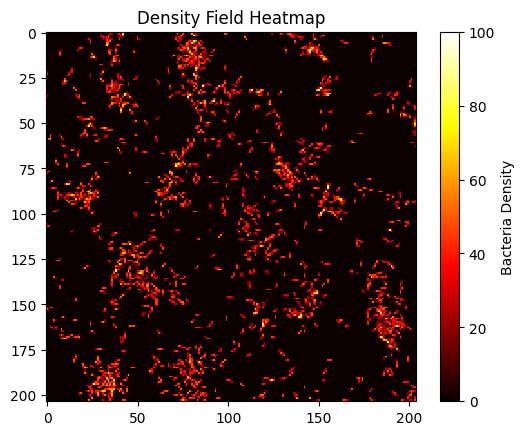

In [11]:
binary_image=opening
# Compute the density field for the current frame
density_field_current = compute_density_field(binary_image, grid_size)

# Visualize the density field using a heatmap
plt.imshow(density_field_current, cmap='hot', interpolation='nearest')
plt.colorbar(label='Bacteria Density')
plt.title('Density Field Heatmap')
plt.show()

## Test the particle tracking algorithms


In [1]:
import matplotlib.pyplot as plt
import trackpy as tp

In [17]:
first_frame=opening
# For the first frame
features = tp.locate(first_frame, diameter=(13,43), separation=15, topn=1000)
#trajectories.append(features)

C:\Users\j-wu1\anaconda3\envs\collect_track\lib\site-packages\trackpy\uncertainty.py:49: RuntimeWarning: invalid value encountered in divide
  N_S = noise / mass


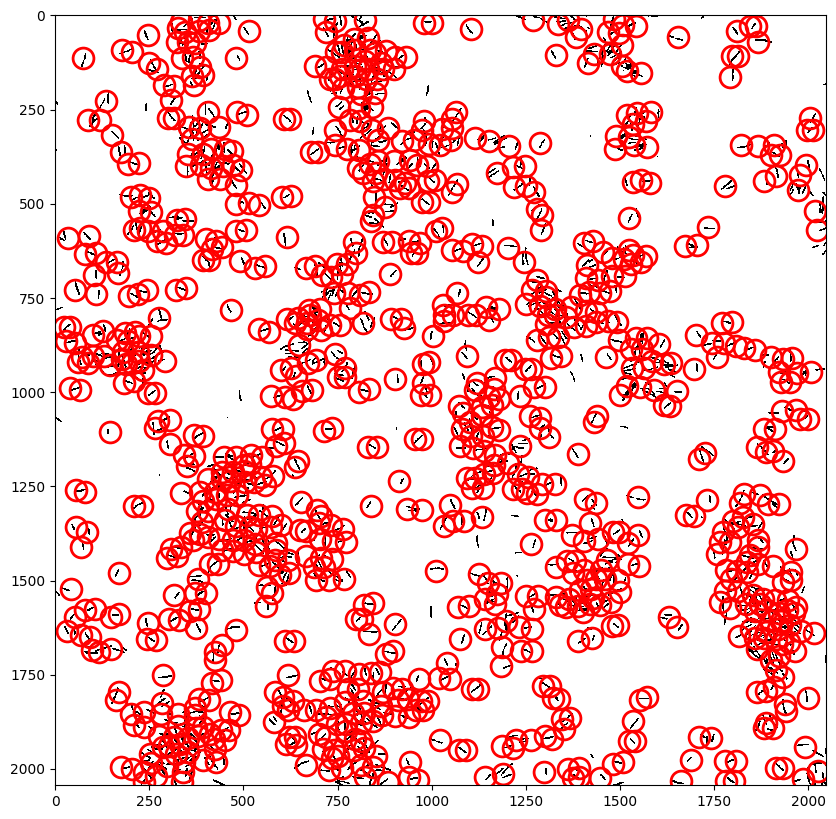

In [18]:
plt.figure(figsize=(10,10))
tp.annotate(features, first_frame)
plt.show()

In [3]:
with tiff.TiffFile(image_path) as tif:
#    frames = tif.asarray()
     frame2 = tif.asarray(key=1)

In [38]:
def preprocessing(frame):
    image=frame
    
    # Preprocess
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = image
    # Apply bilateral filter
    bilateral = cv2.bilateralFilter(gray, 25, 50, 50)
    
    # Apply Otsu's thresholding
    _, binary = cv2.threshold(bilateral, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Morphological opening to remove small noise
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    return opening

In [5]:
def preprocessingwater(frame):

    image = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    # Use adaptive thresholding
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    # Noise removal
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Sure background
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Sure foreground
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    
    # Unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Label markers
    _, markers = cv2.connectedComponents(sure_fg)
    
    # Add 1 to all labels to distinguish sure regions from unknown regions
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = markers.astype(np.int32)
    # Apply watershed
    cv2.watershed(image, markers)
    image[markers == -1] = [0]
    return image

In [7]:

simg=preprocessing(frame2)
aspect_ratio = simg.shape[1] / float(simg.shape[0])
desired_width = 600
desired_height = int(desired_width / aspect_ratio)
resized = cv2.resize(simg, (desired_width, desired_height))
cv2.imshow('Resized Image with Aspect Ratio', resized)
cv2.waitKey(0)

-1

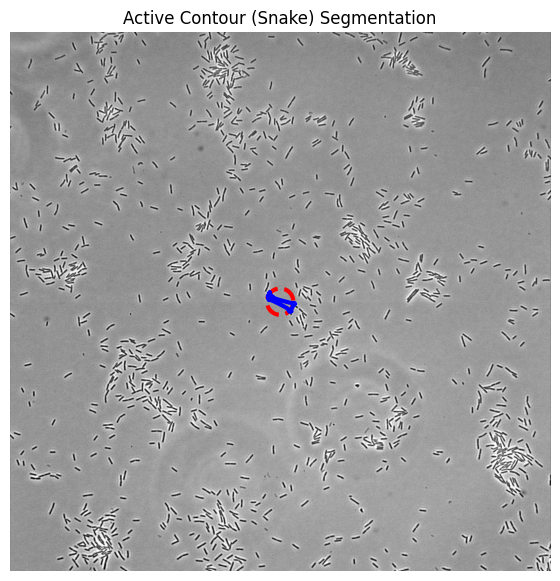

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.segmentation import active_contour

def active_contour_segmentation(image):
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        image = rgb2gray(image)
    
    # Smooth the image slightly with a Gaussian filter
    image_smooth = gaussian(image, 2)
    
    # Define an initial circular contour (snake) inside the object
    s = np.linspace(0, 2*np.pi, 400)
    r = image.shape[0] / 2 + 50 * np.sin(s)
    c = image.shape[1] / 2 + 50 * np.cos(s)
    init = np.array([r, c]).T
    
    # Evolve the contour
    snake = active_contour(image_smooth, init, alpha=0.015, beta=10, gamma=0.001)
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3, label='Initial contour')
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3, label='Active contour')
    ax.set_title("Active Contour (Snake) Segmentation")
    ax.axis('off')
    plt.show()

# Apply the function
active_contour_segmentation(frame2)

In [12]:

# Global variables
zoom_level = 1
zoom_center = (0, 0)

def zoom_image(img, zoom_factor, center):
    ''' Zooms (in/out) an image '''
    height, width = img.shape[:2]
    new_width = int(width * zoom_factor)
    new_height = int(height * zoom_factor)
    x_offset = int((new_width - width) / 2)
    y_offset = int((new_height - height) / 2)
    
    # Create a zoomed image
    zoomed = cv2.resize(img, (new_width, new_height))
    
    # Crop to original size with the center at the mouse position
    left = max(0, center[0] - width // 2 + x_offset)
    top = max(0, center[1] - height // 2 + y_offset)
    right = min(new_width, left + width)
    bottom = min(new_height, top + height)
    
    cropped = zoomed[top:bottom, left:right]
    
    return cropped

def mouse_callback(event, x, y, flags, param):
    ''' Mouse callback function for zooming '''
    global zoom_level, zoom_center
    
    # Check for mouse wheel event
    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:  # Scroll up to zoom in
            zoom_level += 0.1
        else:  # Scroll down to zoom out
            zoom_level -= 0.1
        
        # Ensure zoom level is within a reasonable range
        zoom_level = max(0.1, zoom_level)  # Prevent zooming out too much
        
        zoom_center = (x, y)
        
        # Apply zoom and display the image
        zoomed_img = zoom_image(simg, zoom_level, zoom_center)
        cv2.imshow('Resized Image with Aspect Ratio', zoomed_img)

# Calculate aspect ratio and resize
aspect_ratio = simg.shape[1] / float(simg.shape[0])
desired_width = 600
desired_height = int(desired_width / aspect_ratio)
resized = cv2.resize(simg, (desired_width, desired_height))

# Show the image and set the mouse callback
cv2.imshow('Resized Image with Aspect Ratio', resized)
cv2.setMouseCallback('Resized Image with Aspect Ratio', mouse_callback)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
# Calculate the velocity field between two density fields
def compute_velocity_field(density_field1, density_field2, time_step):
    # For simplicity, we'll calculate the difference between the two fields
    # This is a basic approach; more sophisticated methods can be used
    velocity_field = (density_field2 - density_field1) / time_step
    return velocity_field

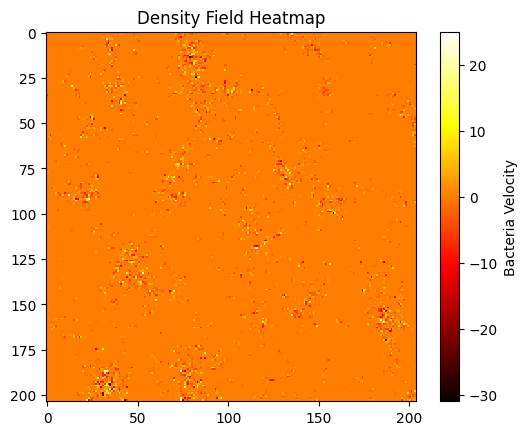

In [18]:
# Compute the density field for the current frame
density_field_2 = compute_density_field(simg, grid_size)

density_velo = compute_velocity_field(density_field_current, density_field_2,1)

# Visualize the density field using a heatmap
plt.imshow(density_velo, cmap='hot', interpolation='nearest')
plt.colorbar(label='Bacteria Velocity')
plt.title('Density Field Heatmap')
plt.show()

In [1]:
import cv2
import numpy as np
import tifffile as tiff
import imageio
import matplotlib.pyplot as plt
image_path = 'D:\Temp_WS_10_2023\RAW_IMG\pilG_dilute_PC.tif'

In [37]:
def preprocessing(frame):
    image=frame
    
    # Preprocess
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = image
    # Apply bilateral filter
    bilateral = cv2.bilateralFilter(gray, 25, 50, 50)
    
    # Apply Otsu's thresholding
    _, binary = cv2.threshold(bilateral, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Morphological opening to remove small noise
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    return opening

In [10]:
# Calculate the density field for a given frame
def compute_density_field(frame, grid_size):
    height, width = frame.shape
    density_field = np.zeros((height // grid_size, width // grid_size))
    
    for i in range(0, height-grid_size, grid_size):
        for j in range(0, width-grid_size, grid_size):
            cell = frame[i:i+grid_size, j:j+grid_size]
            density = np.sum(cell == 0)  # Count black pixels (bacteria)
            density_field[i // grid_size, j // grid_size] = density
    
    return density_field

In [11]:
# Calculate the velocity field between two density fields
def compute_velocity_field(density_field1, density_field2, time_step):
    # For simplicity, we'll calculate the difference between the two fields
    # This is a basic approach; more sophisticated methods can be used
    velocity_field = (density_field2 - density_field1) / time_step
    return velocity_field

In [53]:
def render_density_field_to_image(density_field, title):
    """Render a density field numpy array to an image."""
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(density_field, cmap='hot')  # Store the result in 'im'
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    fig.colorbar(im, ax=ax)  # Use 'im' here for the colorbar
    ax.axis('off')  # Turn off the axis numbers and ticks
    fig.tight_layout()  # Adjust layout to fit colorbar
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image


In [67]:
den_fields = []
velo_fields = []
num_frames_to_process = 238
grid_size = 10  # Size of each grid cell
for idx in range(num_frames_to_process):
    with tiff.TiffFile(image_path) as tif:
    #    frames = tif.asarray()
         fra = tif.asarray(key=idx)
    bimg=preprocessing(fra)
    den_field_current = compute_density_field(bimg, grid_size)
    den_fields.append(den_field_current)
    print(f"Processing image {idx + 1}/{num_frames_to_process}...")
    # Compute the velocity field if it's not the first frame
    if idx > 0:
        velo_field = compute_velocity_field(den_fields[-2], den_fields[-1], 1)
        velo_fields.append(velo_field)


Processing image 1/238...
Processing image 2/238...
Processing image 3/238...
Processing image 4/238...
Processing image 5/238...
Processing image 6/238...
Processing image 7/238...
Processing image 8/238...
Processing image 9/238...
Processing image 10/238...
Processing image 11/238...
Processing image 12/238...
Processing image 13/238...
Processing image 14/238...
Processing image 15/238...
Processing image 16/238...
Processing image 17/238...
Processing image 18/238...
Processing image 19/238...
Processing image 20/238...
Processing image 21/238...
Processing image 22/238...
Processing image 23/238...
Processing image 24/238...
Processing image 25/238...
Processing image 26/238...
Processing image 27/238...
Processing image 28/238...
Processing image 29/238...
Processing image 30/238...
Processing image 31/238...
Processing image 32/238...
Processing image 33/238...
Processing image 34/238...
Processing image 35/238...
Processing image 36/238...
Processing image 37/238...
Processing

In [68]:
# Convert density_fields and velocity_fields to lists of images
density_images = [render_density_field_to_image3(df, 'Density Field', timestep=i) for i, df in enumerate(den_fields)]
velocity_images = [render_density_field_to_image3(vf, 'Velocity_field', timestep=i) for i, vf in enumerate(velo_fields)]

# Create animated .gif of the density and velocity fields
density_gif_path = 'density_animation.gif'
velocity_gif_path = 'velocity_animation.gif'

imageio.mimsave(density_gif_path, density_images, duration=0.5)
imageio.mimsave(velocity_gif_path, velocity_images, duration=0.5)

In [2]:
image_path2 = 'D:\Temp_WS_10_2023\RAW_IMG\pilG_dense_PC.tif'

In [3]:
def preprocessing2(frame):
    image = frame
    
    # Convert to grayscale if the image is not already grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)

    # Apply bilateral filter
    bilateral = cv2.bilateralFilter(equalized, 25, 50, 50)

    # Apply adaptive thresholding
    binary = cv2.adaptiveThreshold(bilateral, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Morphological opening to remove small noise
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Optional: Morphological closing to fill small holes
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    # Invert the colors to make bacteria black and background white
    inverted = cv2.bitwise_not(closing)
    return inverted


In [30]:
def preprocessing3b(frame):
        # Convert the image to grayscale (if not already)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) if len(frame.shape) == 3 else frame
        
        # Threshold the image
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter out small contours based on area (optional)
        min_area = 50  # Adjust this value based on your requirements
        contours = [c for c in contours if cv2.contourArea(c) > min_area]
        
        # Create an empty binary image
        binary_img = np.ones_like(gray) * 255  # Background set to white
        
        # Fill the detected contours with black
        cv2.drawContours(binary_img, contours, -1, (0), thickness=cv2.FILLED)
    
        return binary_img

In [4]:
def render_density_field_to_image2(density_field, title):
    """Render a density field numpy array to an image."""
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Define fixed bounds for the colormap
    vmin = -200  # or any other lower bound based on your data
    vmax = 200  # or any other upper bound based on your data
    
    im = ax.imshow(density_field, cmap='hot', vmin=vmin, vmax=vmax)  # Set vmin and vmax here
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = fig.colorbar(im, ax=ax)  # Use 'im' here for the colorbar
    cbar.set_label('Density', rotation=270, labelpad=15)  # Label for the colorbar
    ax.axis('off')  # Turn off the axis numbers and ticks
    fig.tight_layout()  # Adjust layout to fit colorbar
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image

In [5]:
def render_density_field_to_image3(density_field, title, timestep):
    """Render a density field numpy array to an image with title and labels."""
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(density_field, cmap='hot')
    ax.set_title(f"{title} - Time Step: {timestep}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('on')  # Turn off the axis numbers and ticks
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image

In [33]:
with tiff.TiffFile(image_path) as tif:
    #    frames = tif.asarray()
    fra = tif.asarray(key=1)

In [39]:
bimg=preprocessing(fra)
simg=bimg
aspect_ratio = simg.shape[1] / float(simg.shape[0])
desired_width = 1000
desired_height = int(desired_width / aspect_ratio)
resized = cv2.resize(simg, (desired_width, desired_height))
cv2.imshow('Resized Image with Aspect Ratio', resized)
cv2.waitKey(0)

-1

In [64]:
den_fields = []
velo_fields = []
num_frames_to_process = 299
grid_size = 10  # Size of each grid cell

for idx in range(num_frames_to_process):
    with tiff.TiffFile(image_path2) as tif:
    #    frames = tif.asarray()
         fra = tif.asarray(key=idx)
    bimg=preprocessing2(fra)
    den_field_current = compute_density_field(bimg, grid_size)
    den_fields.append(den_field_current)
    print(f"Processing image {idx + 1}/{num_frames_to_process}...")
    # Compute the velocity field if it's not the first frame
    if idx > 0:
        velo_field = compute_velocity_field(den_fields[-2], den_fields[-1], 1)
        velo_fields.append(velo_field)

Processing image 1/299...
Processing image 2/299...
Processing image 3/299...
Processing image 4/299...
Processing image 5/299...
Processing image 6/299...
Processing image 7/299...
Processing image 8/299...
Processing image 9/299...
Processing image 10/299...
Processing image 11/299...
Processing image 12/299...
Processing image 13/299...
Processing image 14/299...
Processing image 15/299...
Processing image 16/299...
Processing image 17/299...
Processing image 18/299...
Processing image 19/299...
Processing image 20/299...
Processing image 21/299...
Processing image 22/299...
Processing image 23/299...
Processing image 24/299...
Processing image 25/299...
Processing image 26/299...
Processing image 27/299...
Processing image 28/299...
Processing image 29/299...
Processing image 30/299...
Processing image 31/299...
Processing image 32/299...
Processing image 33/299...
Processing image 34/299...
Processing image 35/299...
Processing image 36/299...
Processing image 37/299...
Processing

In [65]:
len(den_fields)

299

In [66]:
# Convert density_fields and velocity_fields to lists of images
density_images = [render_density_field_to_image3(df, 'Density Field', timestep=i) for i, df in enumerate(den_fields)]
velocity_images = [render_density_field_to_image3(vf, 'Velocity_field', timestep=i) for i, vf in enumerate(velo_fields)]

# Create animated .gif of the density and velocity fields
density_gif_path = 'density_animation.gif'
velocity_gif_path = 'velocity_animation.gif'

imageio.mimsave(density_gif_path, density_images, duration=0.5)
imageio.mimsave(velocity_gif_path, velocity_images, duration=0.5)

## Below is the code for individual bacteria identification and tracking, But the computation is too cumbersome

In [55]:
vis = binary.copy()
vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)
w1=10
h1=32
# Convert to color for drawing
#vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)
rect1 = cv2.minAreaRect(np.array([(50,50)]))
# Set size 
# rect[1] = (width, height)
# # Set angle
# rect[2] = angle  
rect1 = (rect1[0], (w1, h1), 90)
# Draw each rotated rect
box = cv2.boxPoints(rect1) 
box = np.int0(box)
cv2.drawContours(vis,[box],-1,(0, 0, 255),1) 

# Show image with rectangles    
cv2.imshow('Detected Particles', vis)
cv2.waitKey(0)

-1

In [5]:
# Parameters
binary=opening

width = 10
height =32
delta_angle = 1  
ignore_ratio = 0.1
delta_x = 2
delta_y = 2
max_allowed_angle_diff = 20
max_allowed_center_diff_factor = 1.5
max_allowed_perp_center_diff_factor = 10
# Detect rotated rects
rects = []
for angle in range(0, 180, delta_angle):
    rotated = cv2.getRotationMatrix2D((0,0), angle, 1)
    template = cv2.warpAffine(np.zeros((height, width), np.uint8), rotated, (width, height)) 

    res = cv2.matchTemplate(binary, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= 1 - ignore_ratio)
    
    for pt in zip(*loc[::-1]): 
        # pt_mat = cv2.matFromArray(pt, force_type=cv2.CV_32F)
        # pt_umat = cv2.UMat(pt_mat,(1,2)) 
        # rect = cv2.minAreaRect(pt_umat.get()) 
        rect = cv2.minAreaRect(np.array([pt]))
        # Set size 
        # rect[1] = (width, height)
        # # Set angle
        # rect[2] = angle  
        rect = (rect[0], (width, height), angle)
        rects.append(rect)

MemoryError: 

In [10]:
binary_image=opening

template = np.zeros((30, 10), np.uint8) * 255

# Function to perform template matching for a given angle
def match_template_at_angle(image, template, angle):
    rot_mat = cv2.getRotationMatrix2D((5, 15), angle, 1)
    rotated_template = cv2.warpAffine(template, rot_mat, (10, 30))
    res = cv2.matchTemplate(image, rotated_template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.99
    loc = np.where(res >= threshold)
    return zip(*loc[::-1])

# Perform template matching for various angles
all_matched_points = []
for angle in range(0, 180, 10):
    matched_points = match_template_at_angle(binary_image, template, angle)
    all_matched_points.extend(matched_points)

# For demonstration purposes, draw the matched points on the image
for pt in all_matched_points:
    cv2.rectangle(binary_image, pt, (pt[0] + 10, pt[1] + 30), (0, 0, 255), 2)

# Display the image with matched points
cv2.imshow('Matched Points', binary_image)
cv2.waitKey(0)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 33521640 bytes in function 'cv::OutOfMemoryError'


In [9]:
len(all_matched_points)

6034983

In [10]:
# Create a blank image
blank_img = np.zeros((100, 100), dtype=np.uint8)

# Create a raw rectangle
raw_rect = np.ones((30, 70), np.uint8) * 255

# Place the raw rectangle on the blank image at a specified position
blank_img[10:40, 10:80] = raw_rect

# Create a rotated rectangle
rot1 = cv2.getRotationMatrix2D((35, 15), 60, 1)
rotated_rect = cv2.warpAffine(np.ones((30, 70), np.uint8) * 255, rot1, (100, 100))
box = np.int0(rotated_rect)
# Combine the raw rectangle and the rotated rectangle
combined_img = cv2.bitwise_or(blank_img, rotated_rect)

# Display the combined image
cv2.imshow('Detected Particles', combined_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [44]:
# Group into contours
contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

groups = []
for c in contours:
    group = [r for r in rects if cv2.pointPolygonTest(c, r.center, False) > 0]
    groups.append(group)

In [60]:
rect2 = cv2.minAreaRect(np.array([(50,50)]))
rect2[1]

(0.0, 0.0)

In [51]:
# Filter groups 
particles = []
for group in groups:
    for i, r1 in enumerate(group):
        for r2 in group[i+1:]:
            # Check if pair seems to be same particle
            if abs(r1.angle - r2.angle) > max_allowed_angle_diff:
                continue 
            dcenter = np.linalg.norm(r1.center - r2.center)
            if dcenter > max_allowed_center_diff_factor * r1.size[1]:
                continue
            # ...
            
            # If part of same particle, merge rects
            merged = cv2.minAreaRect(np.concatenate((r1.boxPoints, r2.boxPoints)))
            particles.append(merged)

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [47]:
vis = binary.copy()
vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)
# Convert to color for drawing
#vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

# Draw each rotated rect
for rect in groups:
    box = cv2.boxPoints(rect) 
    box = np.int0(box)
    cv2.drawContours(vis,[box],-1,(0,0, 255),2) 

# Show image with rectangles    
cv2.imshow('Detected Particles', vis)
cv2.waitKey(0)

SystemError: new style getargs format but argument is not a tuple